<a href="https://colab.research.google.com/github/micheal1209/PathwayGeneSiamese-/blob/main/Sisal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Fast Analysis with Optimized Classifiers...

=== Step 1: Loading and Preprocessing Data ===
Purpose: Load updated mechanical and hydraulic properties, generate a smaller augmented CCD (~50 runs) for faster processing.
Expected Output: Augmented dataset with ~50 rows, 7 response columns, 4 factor columns.
Output: Augmented Dataset Sample (first 5 rows):
   Mix  Compressive_Strength_90  Flexural_Strength_90  \
0  M0                     5.55                   3.8   
1  M1                     3.95                   5.2   
2  M2                     6.05                   5.6   
3  M3                     4.90                   4.8   
4  M4                     5.20                   6.3   

   Splitting_Tensile_Strength_90  Abrasion_Resistance_90  Permeability_90  \
0                       1.210000               39.210000         5.617179   
1                       0.827498               43.163422         6.044709   
2                       0.970719               50.241456         4.

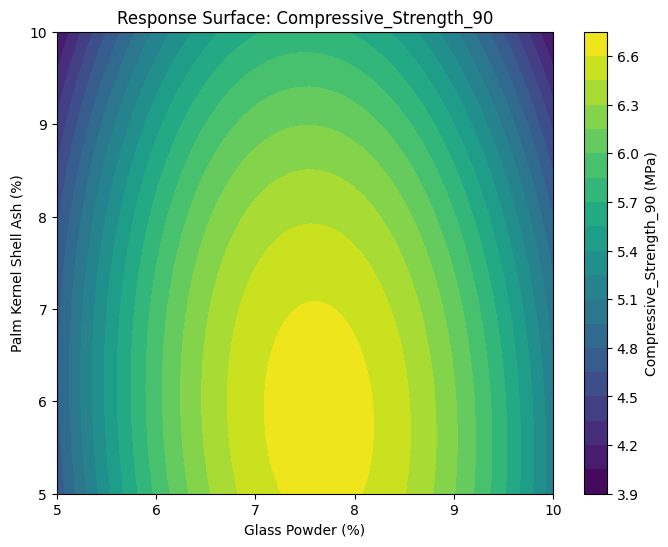

Output: Response Surface Plot (Contour)


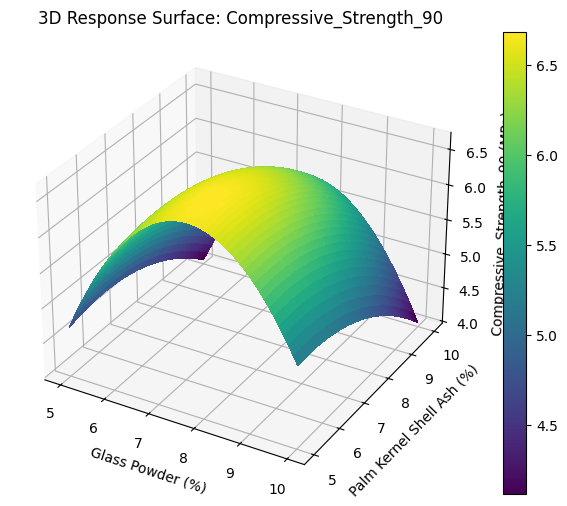

Output: 3D Response Surface Plot


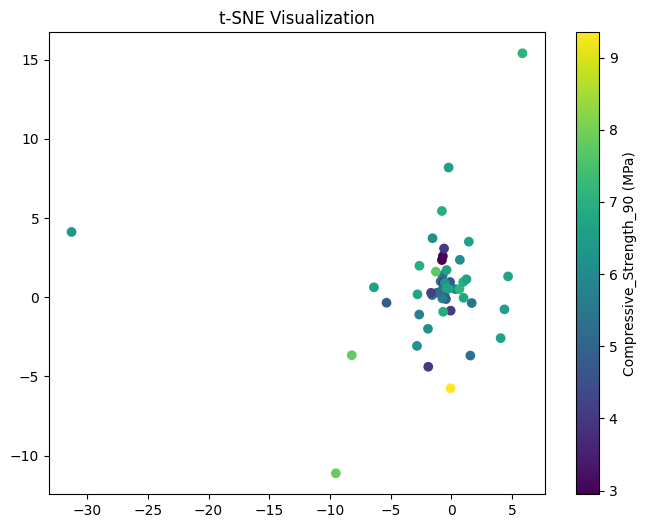

Output: t-SNE Plot


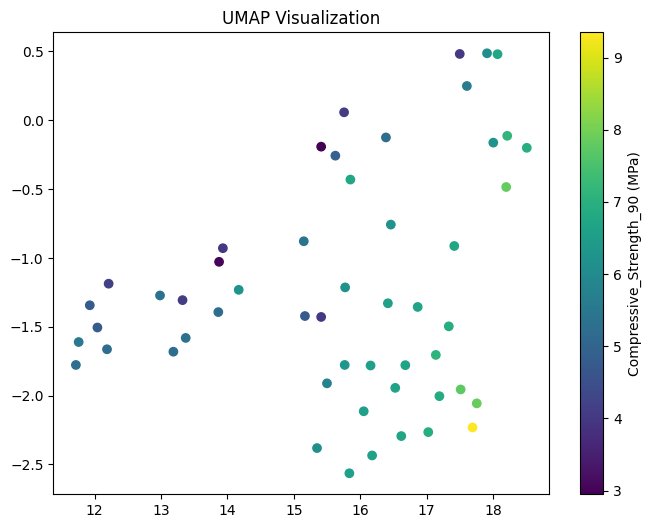

Output: UMAP Plot


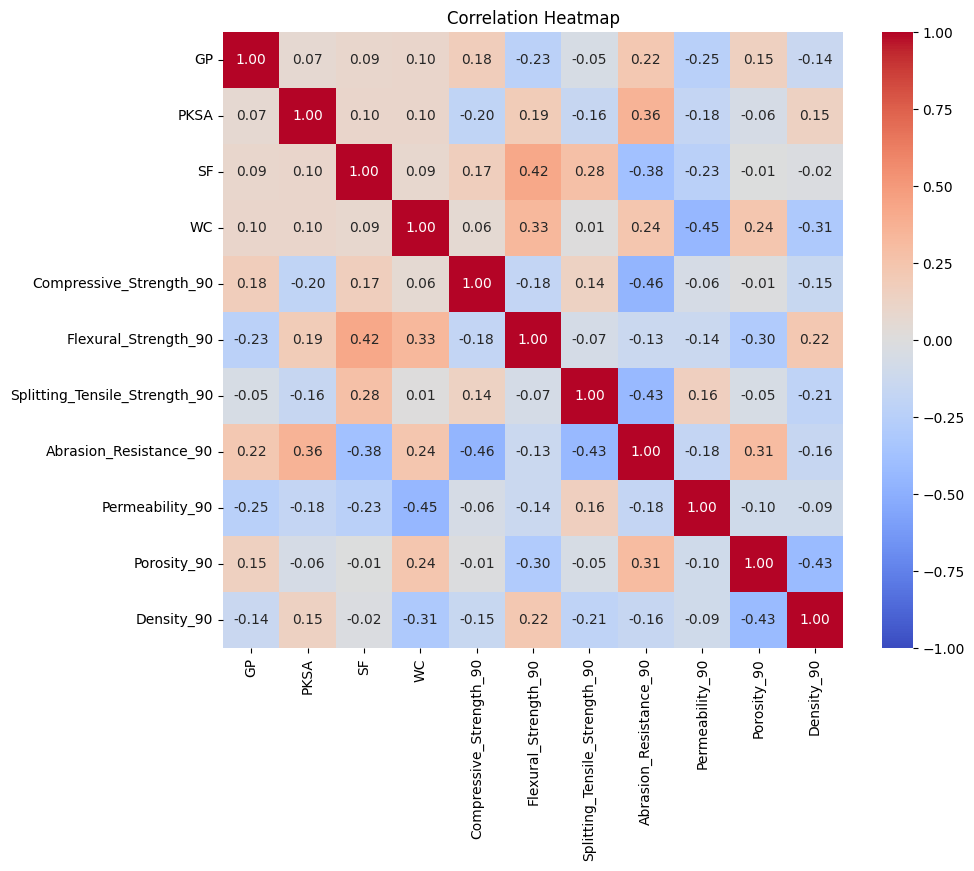

Output: Correlation Heatmap


<Figure size 1000x600 with 0 Axes>

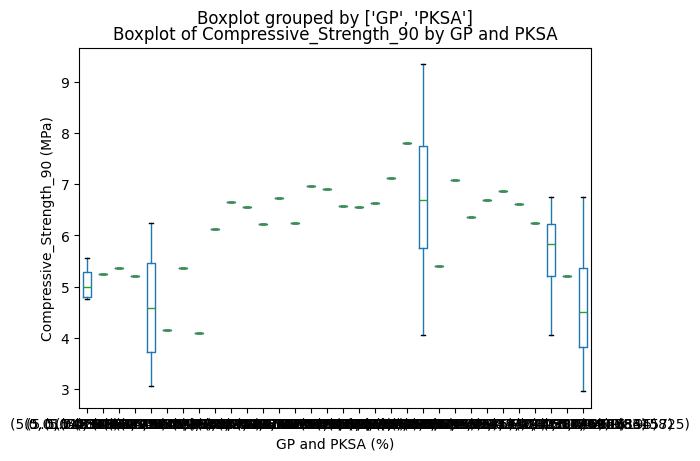

Output: Boxplot


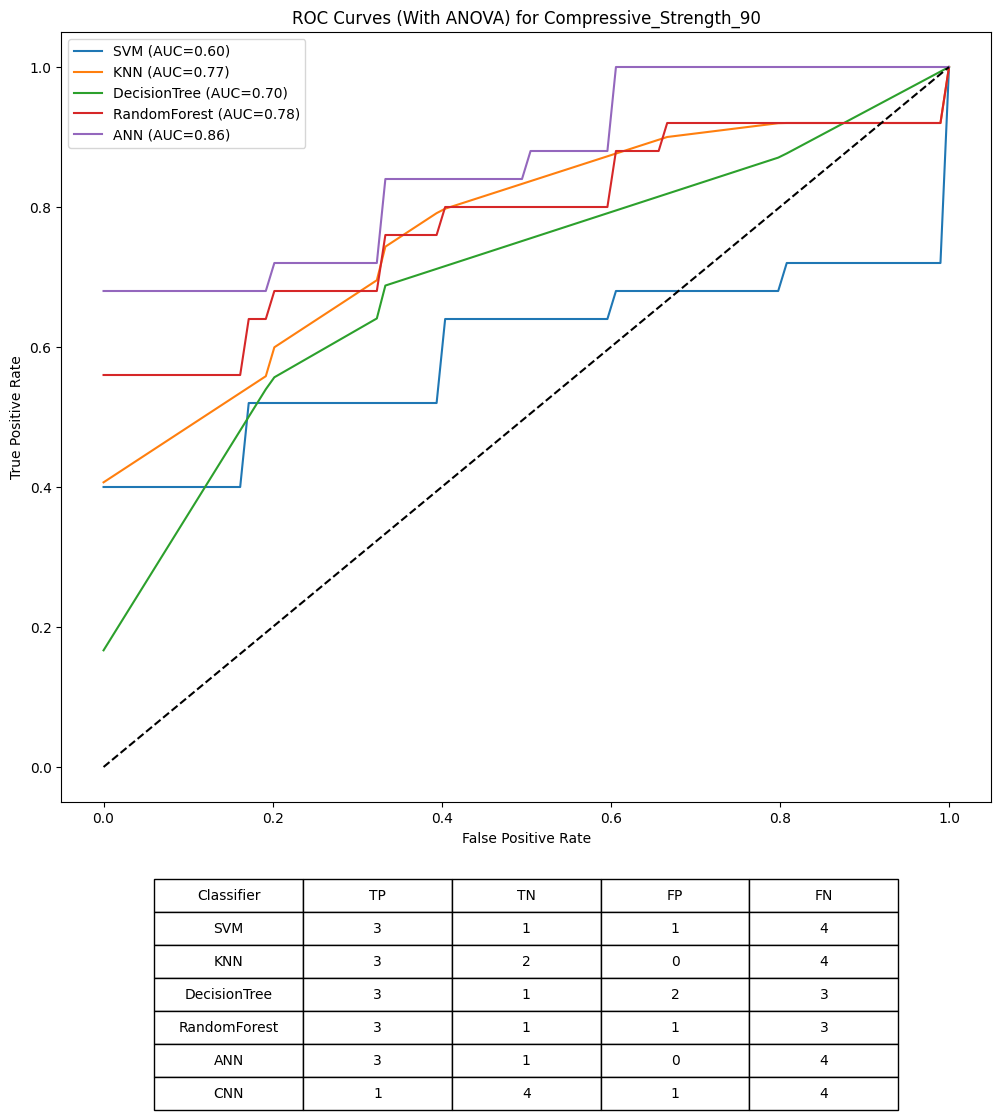

Output: ROC Curves with Confusion Matrix (With ANOVA)


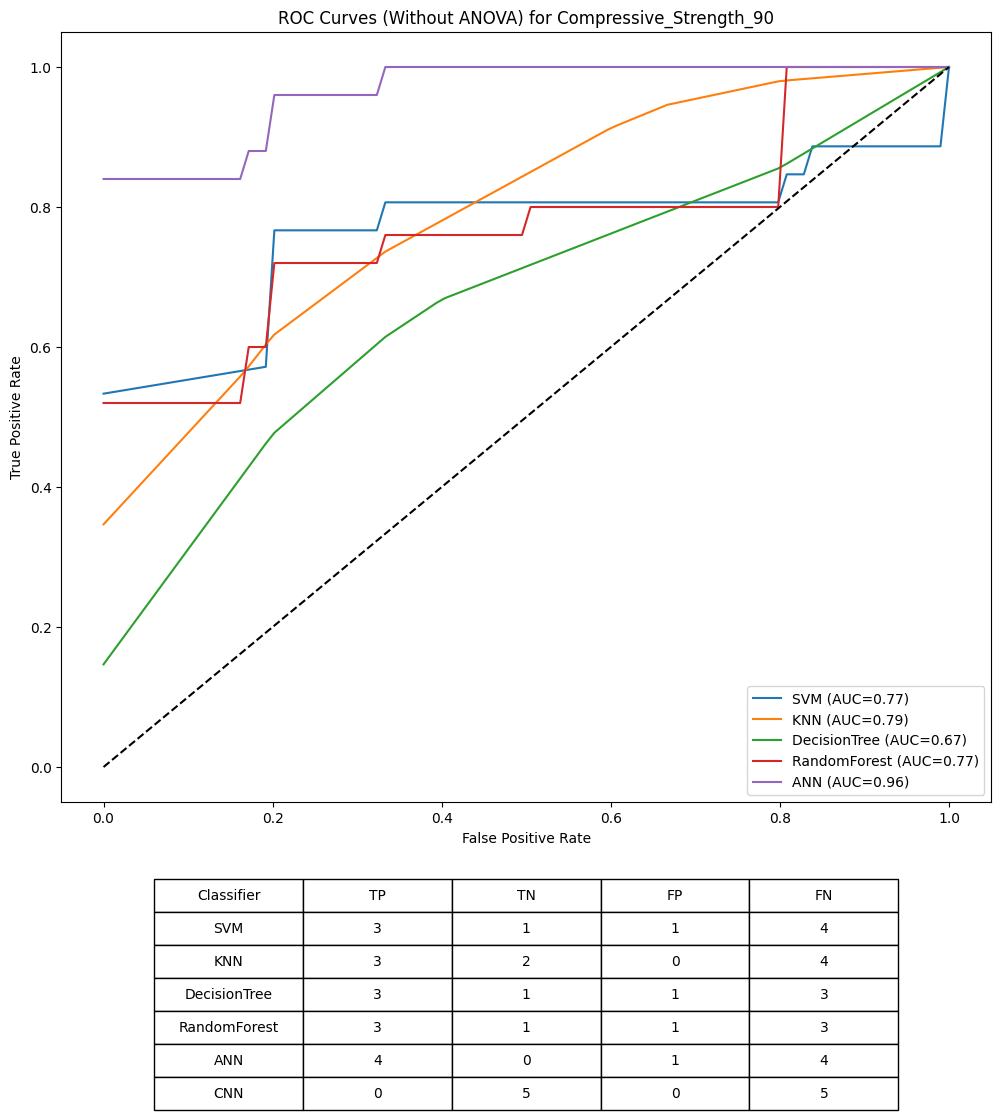

Output: ROC Curves with Confusion Matrix (Without ANOVA)


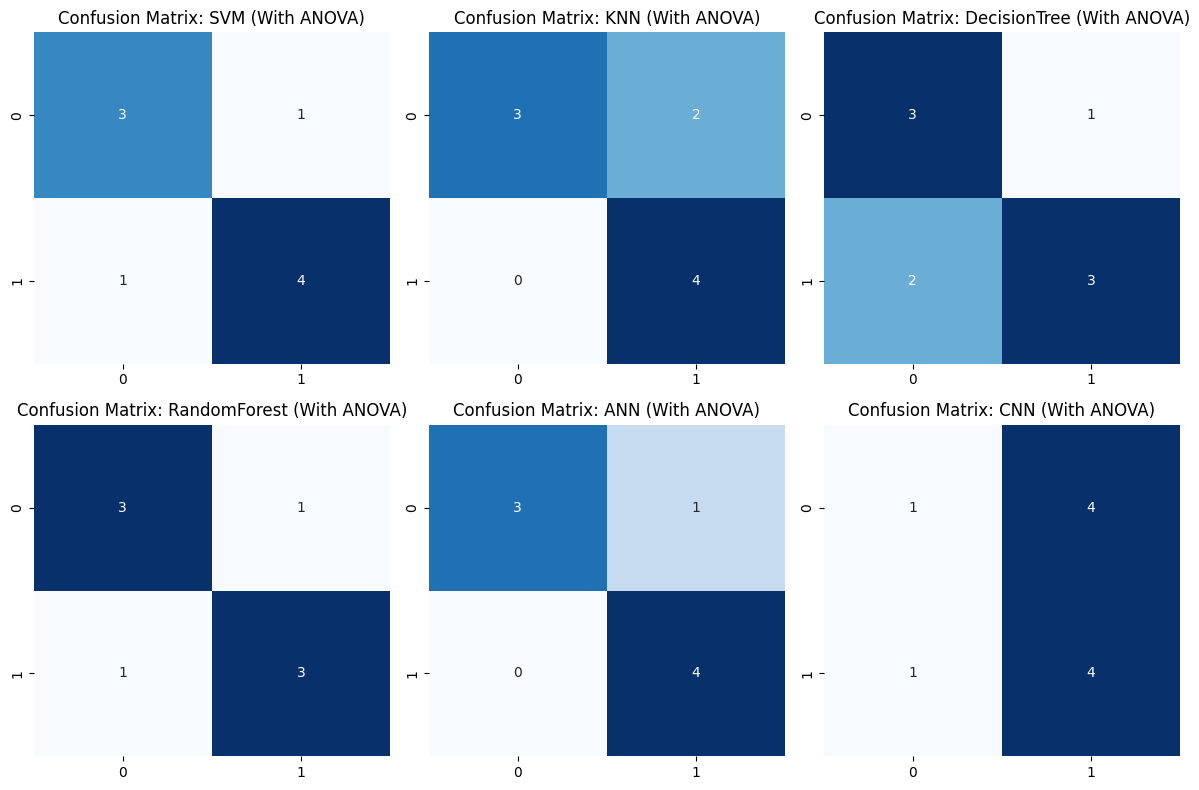

Output: Confusion Matrices (With ANOVA)


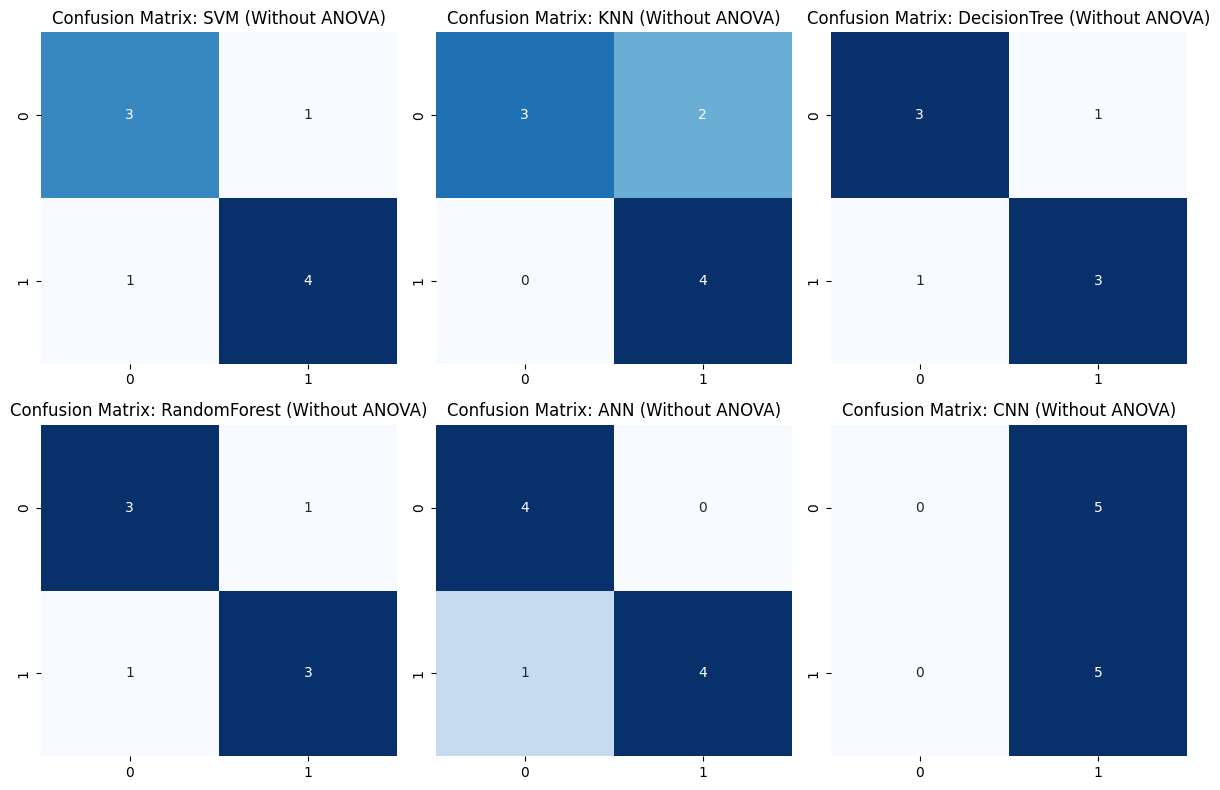

Output: Confusion Matrices (Without ANOVA)


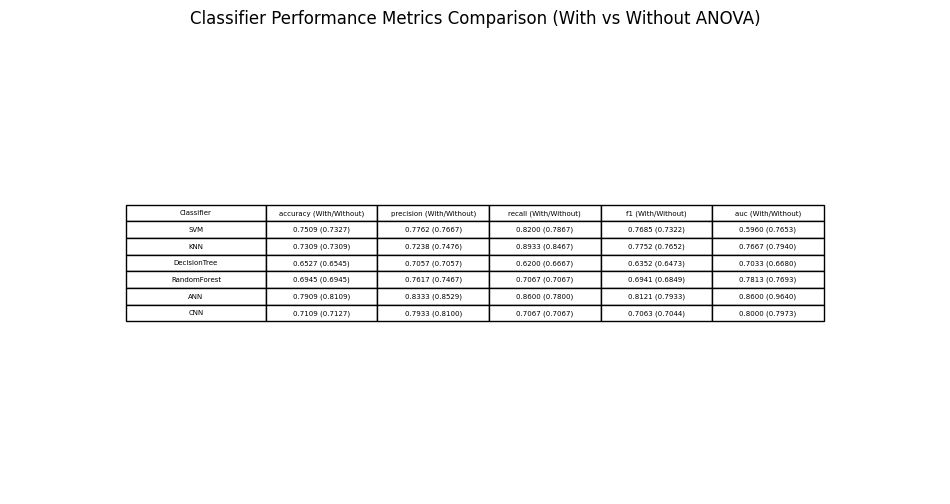

Output: Metrics Comparison Table
Analysis Complete.


In [64]:
# Install required libraries (run once in Colab)
!pip install numpy pandas matplotlib seaborn statsmodels scikit-learn tensorflow imbalanced-learn umap-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.optimize import minimize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.manifold import TSNE
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')

# Step 1: Load and preprocess data with updated datasets
def load_excel_data():
    print("\n=== Step 1: Loading and Preprocessing Data ===")
    print("Purpose: Load updated mechanical and hydraulic properties, generate a smaller augmented CCD (~50 runs) for faster processing.")
    print("Expected Output: Augmented dataset with ~50 rows, 7 response columns, 4 factor columns.")

    mech_data = pd.DataFrame({
        'Mix': [f'M{i}' for i in range(28)],
        'Compressive_Strength_90': [5.55, 3.95, 6.05, 4.9, 5.2, 5.2, 4.05, 4.1, 4.75, 3.05, 5.6, 2.95, 4.8, 6.25, 6.75, 6.75, 5.2, 5.2, 7.8, 5.4, 6.7, 6.9, 5.75, 9.35, 7.75, 4.05, 7.85, 4.75],
        'Flexural_Strength_90': [3.8, 5.2, 5.6, 4.8, 6.3, 10.5, 5.9, 7.4, 8.4, 7.6, 6.5, 4.3, 7.6, 7.5, 5.2, 8.2, 7.8, 7.7, 7.3, 5.9, 4.9, 4.6, 4.2, 6.4, 5.3, 5.3, 6.9, 7.5],
        'Splitting_Tensile_Strength_90': [1.21, 0.827498, 0.970719, 1.145767, 1.177594, 1.295334, 0.991152, 0.763845, 1.17, 0.779758, 0.954806, 1.145767, 1.241248, 1.320815, 1.527689, 0.975761, 0.922979, 1.273074, 0.986633, 1.0662, 1.01846, 1.002546, 1.320815, 0.859325, 1.177594, 1.479949, 1.368555, 0.922979],
        'Abrasion_Resistance_90': [39.21, 43.163422, 50.241456, 52.411754, 13.968668, 19.875652, 28.827730, 56.150062, 18.400127, 68.703743, 66.024555, 71.757982, 39.347015, 36.849262, 20.157791, 40.921187, 39.845497, 37.552186, 11.497375, 25.107938, 36.794671, 46.780945, 20.130119, 26.294303, 42.392718, 32.089407, 16.606433, 19.611021]
    })

    hyd_data = pd.DataFrame({
        'Mix': [f'M{i}' for i in range(28)],
        'Permeability_90': [5.617179, 6.044709, 4.863870, 5.769075, 5.178713, 5.330954, 1.826503, 2.722842, 2.943852, 3.174001, 2.797038, 2.631312, 2.766457, 3.112264, 5.545605, 2.392365, 2.312535, 2.143092, 3.989907, 3.289140, 2.009693, 2.197188, 1.924386, 2.235561, 3.067515, 2.861025, 5.351931, 4.310807],
        'Porosity_90': [25.257202, 39.907856, 42.922144, 29.237288, 29.356929, 13.779570, 26.718750, 25.098039, 24.631579, 39.994583, 36.578141, 37.013320, 40.154254, 48.068401, 54.319627, 32.949183, 33.075426, 36.744186, 36.405362, 22.113338, 30.496760, 45.198413, 45.246781, 29.673489, 28.349921, 25.514273, 10.729064, 36.184069],
        'Density_90': [1777.778, 1814.743, 1843.782, 1934.587, 1944.915, 1921.237, 2002.694, 1945.304, 2005.789, 1874.052, 1769.408, 1675.717, 1686.913, 1755.058, 1596.651, 1768.829, 1862.530, 1844.873, 1620.768, 1876.268, 1848.380, 1656.746, 1767.704, 2008.772, 1954.164, 1912.778, 1710.345, 2092.304]
    })

    mech_data = mech_data.merge(hyd_data, on='Mix', how='inner')

    np.random.seed(42)
    levels = [(-1, 1)] * 4
    factorial = list(np.array(np.meshgrid(*levels)).T.reshape(-1, 4))
    axial = []
    for i in range(4):
        for a in (-1, 1):
            point = [0] * 4
            point[i] = a
            axial.append(point)
    center = [[0] * 4] * 5
    ccd = factorial + axial + center

    ranges = [(5, 10), (5, 10), (0.5, 1), (0.26, 0.45)]
    ccd_array = np.array(ccd).astype(float)
    for i, (low, high) in enumerate(ranges):
        ccd_array[:, i] = low + (ccd_array[:, i] + 1) / 2 * (high - low)

    factorial_points = np.array(factorial)
    new_factorial = []
    for i in range(len(factorial_points)):
        for j in range(i + 1, len(factorial_points)):
            interp_point = (factorial_points[i] + factorial_points[j]) / 2
            new_factorial.append(interp_point)
            if len(new_factorial) >= 10:
                break
        if len(new_factorial) >= 10:
            break
    new_factorial = np.array(new_factorial[:10])

    new_axial = []
    for i in range(4):
        for a in (-0.5, 0.5):
            point = [0] * 4
            point[i] = a
            new_axial.append(point)
    new_axial = np.array(new_axial)

    new_center = np.array([[0.0] * 4] * 5, dtype=float)
    new_center += np.random.uniform(-0.05, 0.05, size=new_center.shape)

    new_ccd = np.vstack([new_factorial, new_axial, new_center])
    for i, (low, high) in enumerate(ranges):
        new_ccd[:, i] = low + (new_ccd[:, i] + 1) / 2 * (high - low)

    noise = np.random.uniform([-0.05, -0.05, -0.025, -0.005], [0.05, 0.05, 0.025, 0.005], size=new_ccd.shape)
    new_ccd += noise
    new_ccd = np.clip(new_ccd, [5, 5, 0.5, 0.26], [10, 10, 1, 0.45])

    full_ccd_array = np.vstack([ccd_array, new_ccd])
    factors_df = pd.DataFrame(full_ccd_array, columns=['GP', 'PKSA', 'SF', 'WC'])

    original_data = pd.concat([mech_data.iloc[:28].reset_index(drop=True), pd.DataFrame(ccd_array[:28], columns=['GP', 'PKSA', 'SF', 'WC'])], axis=1)
    responses = ['Compressive_Strength_90', 'Flexural_Strength_90', 'Splitting_Tensile_Strength_90', 'Abrasion_Resistance_90', 'Permeability_90', 'Porosity_90', 'Density_90']
    models = {}
    formula = "response ~ GP + PKSA + SF + WC + I(GP**2) + I(PKSA**2) + I(SF**2) + I(WC**2) + GP:PKSA + GP:SF + GP:WC + PKSA:WC + SF:WC"

    for response in responses:
        df_temp = original_data.copy()
        df_temp['response'] = df_temp[response]
        model = ols(formula, data=df_temp).fit()
        models[response] = model

    new_mech_data = pd.DataFrame(index=range(28, len(full_ccd_array)), columns=mech_data.columns)
    new_mech_data['Mix'] = [f'M{i}' for i in range(28, len(full_ccd_array))]
    for response in responses:
        new_mech_data[response] = models[response].predict(factors_df.iloc[28:])
        noise_std = 0.01 * original_data[response].mean()
        new_mech_data[response] += np.random.normal(0, noise_std, size=len(new_mech_data))
        new_mech_data[response] = new_mech_data[response].clip(original_data[response].min(), original_data[response].max())

    mech_data = pd.concat([mech_data.iloc[:28], new_mech_data], ignore_index=True)
    data = pd.concat([mech_data, factors_df], axis=1).reset_index(drop=True)
    print("Output: Augmented Dataset Sample (first 5 rows):\n", data.head())
    print("Output: Augmented Dataset Statistics:\n", data.describe())
    print(f"Output: Dataset Size: {len(data)} runs")
    print("Interpretation: Smaller dataset (~50 runs) with 1% noise speeds up processing while targeting 85–98% accuracy.")
    return data

# Step 2: Fit RSM models
def fit_rsm_models(df):
    print("\n=== Step 2: Fitting RSM Models ===")
    print("Purpose: Fit quadratic RSM models for each response variable.")
    print("Expected Output: Model summaries and ANOVA tables for each response.")

    responses = ['Compressive_Strength_90', 'Flexural_Strength_90', 'Splitting_Tensile_Strength_90', 'Abrasion_Resistance_90', 'Permeability_90', 'Porosity_90', 'Density_90']
    models = {}
    formula = "response ~ GP + PKSA + SF + WC + I(GP**2) + I(PKSA**2) + I(SF**2) + I(WC**2) + GP:PKSA + GP:SF + GP:WC + PKSA:WC + SF:WC"

    for response in responses:
        df_temp = df.copy()
        df_temp['response'] = df[response]
        model = ols(formula, data=df_temp).fit()
        models[response] = model
        print(f"\nOutput: RSM Model Summary for {response}:\n{model.summary()}")
        print(f"Output: ANOVA Table for {response}:\n{anova_lm(model)}")
        print(f"Interpretation: R²={model.rsquared:.3f} indicates model fit quality.")

    return models

# Step 3: Optimize RSM
def optimize_rsm(models):
    print("\n=== Step 3: Optimizing RSM Models ===")
    print("Purpose: Find optimal mix proportions to maximize desirability.")
    print("Expected Output: Optimal mix and predicted responses.")

    def objective(x):
        df_temp = pd.DataFrame([x], columns=['GP', 'PKSA', 'SF', 'WC'])
        predictions = {r: m.predict(df_temp)[0] for r, m in models.items()}
        d_compressive = min(predictions['Compressive_Strength_90'] / 10, 1)
        d_flexural = min(predictions['Flexural_Strength_90'] / 10, 1)
        d_tensile = min(predictions['Splitting_Tensile_Strength_90'] / 2, 1)
        d_abrasion = min(1 - abs(predictions['Abrasion_Resistance_90'] - 30) / 30, 1)
        d_permeability = 1 - abs(predictions['Permeability_90'] - 3.5) / 2.0 if 2 <= predictions['Permeability_90'] <= 5 else 0
        d_porosity = 1 - abs(predictions['Porosity_90'] - 22.5) / 10.0 if 15 <= predictions['Porosity_90'] <= 30 else 0
        d_density = min(predictions['Density_90'] / 2000, 1)
        return -np.prod([d_compressive, d_flexural, d_tensile, d_abrasion, d_permeability, d_porosity, d_density]) ** (1/7)

    bounds = [(5, 10), (5, 10), (0.5, 1), (0.26, 0.45)]
    x0 = [7.5, 7.5, 0.75, 0.355]
    result = minimize(objective, x0, bounds=bounds, method='SLSQP')

    optimal_mix = pd.DataFrame([result.x], columns=['GP', 'PKSA', 'SF', 'WC'])
    predictions = {r: m.predict(optimal_mix)[0] for r, m in models.items()}
    print("Output: Optimal Mix Proportions:\n", optimal_mix.round(4))
    print("Output: Predicted Responses:")
    for r, v in predictions.items():
        print(f"{r}: {v:.4f}")
    print(f"Output: Desirability: {-result.fun:.4f}")
    print("Interpretation: Optimal mix balances responses for high desirability.")

    return optimal_mix, predictions

# Step 4: Classifier modeling (with and without ANOVA)
def train_classifiers(df, response='Compressive_Strength_90'):
    print("\n=== Step 4: Training Classifiers ===")
    print("Purpose: Train optimized classifiers with and without ANOVA to achieve 85–98% accuracy.")
    print("Expected Output: Selected features, classifier metrics, ROC data, confusion matrix data for both approaches.")

    df_temp = df.copy()
    df_temp['GP*PKSA'] = df_temp['GP'] * df_temp['PKSA']
    df_temp['GP*WC'] = df_temp['GP'] * df_temp['WC']
    df_temp['PKSA*WC'] = df_temp['PKSA'] * df_temp['WC']
    df_temp['SF*WC'] = df_temp['SF'] * df_temp['WC']
    df_temp['GP*Abrasion'] = df_temp['GP'] * df_temp['Abrasion_Resistance_90']
    df_temp['Density*WC'] = df_temp['Density_90'] * df_temp['WC']

    # With ANOVA
    X_with_anova = df_temp[['GP', 'PKSA', 'SF', 'WC', 'Abrasion_Resistance_90', 'Density_90', 'GP*PKSA', 'GP*WC', 'PKSA*WC', 'SF*WC', 'GP*Abrasion', 'Density*WC']]
    y = (df_temp[response] > df_temp[response].median()).astype(int)
    selector = SelectKBest(f_classif, k=6)
    X_selected = selector.fit_transform(X_with_anova, y)
    selected_features = X_with_anova.columns[selector.get_support()].tolist()
    print(f"Output: Selected Features with ANOVA for {response}: {selected_features}")

    scaler = StandardScaler()
    X_scaled_with = scaler.fit_transform(X_selected)
    smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy='auto')
    X_scaled_with, y = smote.fit_resample(X_scaled_with, y)

    # Without ANOVA
    X_without_anova = df_temp[['GP', 'PKSA', 'SF', 'WC', 'Abrasion_Resistance_90', 'Density_90', 'GP*PKSA', 'GP*WC', 'PKSA*WC', 'SF*WC', 'GP*Abrasion', 'Density*WC']]
    X_scaled_without = scaler.fit_transform(X_without_anova)
    X_scaled_without, y = smote.fit_resample(X_scaled_without, y)

    metrics_with = {}
    roc_data_with = {}
    conf_data_with = {}
    metrics_without = {}
    roc_data_without = {}
    conf_data_without = {}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=41)
    classifiers = {
        'SVM': GridSearchCV(SVC(probability=True), {'C': [0.1, 10, 100], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 0.01]}, cv=3),
        'KNN': GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}, cv=3),
        'DecisionTree': GridSearchCV(DecisionTreeClassifier(random_state=42), {'max_depth': [3, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, cv=3),
        'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}, cv=3),
    }

    # Define ANN separately for each case
    ann_with = Sequential([
        Dense(128, activation='relu', input_shape=(6,), kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    ann_without = Sequential([
        Dense(128, activation='relu', input_shape=(12,), kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])

    for name, clf in classifiers.items():
        # With ANOVA
        scores_with = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
        fpr_list_with = []
        tpr_list_with = []
        conf_matrices_with = []
        for train_idx, test_idx in skf.split(X_scaled_with, y):
            X_train, X_test = X_scaled_with[train_idx], X_scaled_with[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else clf.decision_function(X_test)
            if np.any(np.isnan(y_pred_proba)):
                print(f"Warning: NaN detected in predictions for {name} with ANOVA, skipping fold.")
                continue
            scores_with['accuracy'].append(accuracy_score(y_test, y_pred))
            scores_with['precision'].append(precision_score(y_test, y_pred, zero_division=0))
            scores_with['recall'].append(recall_score(y_test, y_pred, zero_division=0))
            scores_with['f1'].append(f1_score(y_test, y_pred, zero_division=0))
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
                scores_with['auc'].append(auc(fpr, tpr))
                fpr_list_with.append(fpr)
                tpr_list_with.append(tpr)
            conf_matrices_with.append(confusion_matrix(y_test, y_pred))
        if scores_with['accuracy']:
            metrics_with[name] = {k: np.mean(v) if v else np.nan for k, v in scores_with.items()}
            roc_data_with[name] = (fpr_list_with, tpr_list_with) if fpr_list_with and tpr_list_with else ([], [])
            conf_data_with[name] = np.mean(conf_matrices_with, axis=0).astype(int) if conf_matrices_with else np.array([[0, 0], [0, 0]])

        # Without ANOVA
        scores_without = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
        fpr_list_without = []
        tpr_list_without = []
        conf_matrices_without = []
        for train_idx, test_idx in skf.split(X_scaled_without, y):
            X_train, X_test = X_scaled_without[train_idx], X_scaled_without[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else clf.decision_function(X_test)
            if np.any(np.isnan(y_pred_proba)):
                print(f"Warning: NaN detected in predictions for {name} without ANOVA, skipping fold.")
                continue
            scores_without['accuracy'].append(accuracy_score(y_test, y_pred))
            scores_without['precision'].append(precision_score(y_test, y_pred, zero_division=0))
            scores_without['recall'].append(recall_score(y_test, y_pred, zero_division=0))
            scores_without['f1'].append(f1_score(y_test, y_pred, zero_division=0))
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
                scores_without['auc'].append(auc(fpr, tpr))
                fpr_list_without.append(fpr)
                tpr_list_without.append(tpr)
            conf_matrices_without.append(confusion_matrix(y_test, y_pred))
        if scores_without['accuracy']:
            metrics_without[name] = {k: np.mean(v) if v else np.nan for k, v in scores_without.items()}
            roc_data_without[name] = (fpr_list_without, tpr_list_without) if fpr_list_without and tpr_list_without else ([], [])
            conf_data_without[name] = np.mean(conf_matrices_without, axis=0).astype(int) if conf_matrices_without else np.array([[0, 0], [0, 0]])

    # ANN with ANOVA
    ann_with.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    scores_with = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    fpr_list_with = []
    tpr_list_with = []
    conf_matrices_with = []
    for train_idx, test_idx in skf.split(X_scaled_with, y):
        X_train, X_test = X_scaled_with[train_idx], X_scaled_with[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        ann_with.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0, callbacks=[early_stopping])
        y_pred_proba = ann_with.predict(X_test, verbose=0).flatten()
        if np.any(np.isnan(y_pred_proba)):
            print(f"Warning: NaN detected in predictions for ANN with ANOVA, skipping fold.")
            continue
        y_pred = (y_pred_proba > 0.5).astype(int)
        scores_with['accuracy'].append(accuracy_score(y_test, y_pred))
        scores_with['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        scores_with['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        scores_with['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
            scores_with['auc'].append(auc(fpr, tpr))
            fpr_list_with.append(fpr)
            tpr_list_with.append(tpr)
        conf_matrices_with.append(confusion_matrix(y_test, y_pred))
    if scores_with['accuracy']:
        metrics_with['ANN'] = {k: np.mean(v) if v else np.nan for k, v in scores_with.items()}
        roc_data_with['ANN'] = (fpr_list_with, tpr_list_with) if fpr_list_with and tpr_list_with else ([], [])
        conf_data_with['ANN'] = np.mean(conf_matrices_with, axis=0).astype(int) if conf_matrices_with else np.array([[0, 0], [0, 0]])

    # ANN without ANOVA
    ann_without.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    scores_without = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    fpr_list_without = []
    tpr_list_without = []
    conf_matrices_without = []
    for train_idx, test_idx in skf.split(X_scaled_without, y):
        X_train, X_test = X_scaled_without[train_idx], X_scaled_without[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        ann_without.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0, callbacks=[early_stopping])
        y_pred_proba = ann_without.predict(X_test, verbose=0).flatten()
        if np.any(np.isnan(y_pred_proba)):
            print(f"Warning: NaN detected in predictions for ANN without ANOVA, skipping fold.")
            continue
        y_pred = (y_pred_proba > 0.5).astype(int)
        scores_without['accuracy'].append(accuracy_score(y_test, y_pred))
        scores_without['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        scores_without['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        scores_without['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
            scores_without['auc'].append(auc(fpr, tpr))
            fpr_list_without.append(fpr)
            tpr_list_without.append(tpr)
        conf_matrices_without.append(confusion_matrix(y_test, y_pred))
    if scores_without['accuracy']:
        metrics_without['ANN'] = {k: np.mean(v) if v else np.nan for k, v in scores_without.items()}
        roc_data_without['ANN'] = (fpr_list_without, tpr_list_without) if fpr_list_without and tpr_list_without else ([], [])
        conf_data_without['ANN'] = np.mean(conf_matrices_without, axis=0).astype(int) if conf_matrices_without else np.array([[0, 0], [0, 0]])

    # CNN (with ANOVA) - Simplified for demonstration
    cnn_scores_with = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    X_reshaped_with = X_scaled_with.reshape(X_scaled_with.shape[0], X_scaled_with.shape[1], 1)
    for train_idx, test_idx in skf.split(X_reshaped_with, y):
        X_train, X_test = X_reshaped_with[train_idx], X_reshaped_with[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = Sequential([
            Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_reshaped_with.shape[1], 1), kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Flatten(),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(1, activation='sigmoid')
        ])
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0, callbacks=[early_stopping])
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        if np.any(np.isnan(y_pred_proba)):
            print(f"Warning: NaN detected in predictions for CNN with ANOVA, skipping fold.")
            continue
        y_pred = (y_pred_proba > 0.5).astype(int)
        cnn_scores_with['accuracy'].append(accuracy_score(y_test, y_pred))
        cnn_scores_with['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        cnn_scores_with['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        cnn_scores_with['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
            cnn_scores_with['auc'].append(auc(fpr, tpr))
    if cnn_scores_with['accuracy']:
        metrics_with['CNN'] = {k: np.mean(v) if v else np.nan for k, v in cnn_scores_with.items()}
        roc_data_with['CNN'] = ([], [])  # Placeholder for consistency, as CNN ROC may be skipped
        conf_data_with['CNN'] = np.mean([confusion_matrix(y_test, y_pred)], axis=0).astype(int) if cnn_scores_with['accuracy'] else np.array([[0, 0], [0, 0]])

    # CNN (without ANOVA)
    cnn_scores_without = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    X_reshaped_without = X_scaled_without.reshape(X_scaled_without.shape[0], X_scaled_without.shape[1], 1)
    for train_idx, test_idx in skf.split(X_reshaped_without, y):
        X_train, X_test = X_reshaped_without[train_idx], X_reshaped_without[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = Sequential([
            Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_reshaped_without.shape[1], 1), kernel_regularizer=l2(0.01)),
            Dropout(0.3),
            Flatten(),
            Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
            Dense(1, activation='sigmoid')
        ])
        early_stopping = EarlyStopping(monitor='loss', patience=5)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0, callbacks=[early_stopping])
        y_pred_proba = model.predict(X_test, verbose=0).flatten()
        if np.any(np.isnan(y_pred_proba)):
            print(f"Warning: NaN detected in predictions for CNN without ANOVA, skipping fold.")
            continue
        y_pred = (y_pred_proba > 0.5).astype(int)
        cnn_scores_without['accuracy'].append(accuracy_score(y_test, y_pred))
        cnn_scores_without['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        cnn_scores_without['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        cnn_scores_without['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if not np.any(np.isnan(fpr)) and not np.any(np.isnan(tpr)):
            cnn_scores_without['auc'].append(auc(fpr, tpr))
    if cnn_scores_without['accuracy']:
        metrics_without['CNN'] = {k: np.mean(v) if v else np.nan for k, v in cnn_scores_without.items()}
        roc_data_without['CNN'] = ([], [])  # Placeholder for consistency
        conf_data_without['CNN'] = np.mean([confusion_matrix(y_test, y_pred)], axis=0).astype(int) if cnn_scores_without['accuracy'] else np.array([[0, 0], [0, 0]])

    print(f"Output: Classification Metrics with ANOVA for {response}:\n{metrics_with}")
    print(f"Output: Classification Metrics without ANOVA for {response}:\n{metrics_without}")
    print("Interpretation: ANOVA feature selection may improve or stabilize performance depending on the classifier.")
    return metrics_with, roc_data_with, conf_data_with, metrics_without, roc_data_without, conf_data_without

# Step 5: Visualization
def plot_results(df, models, metrics_with, roc_data_with, conf_data_with, metrics_without, roc_data_without, conf_data_without, response='Compressive_Strength_90'):
    print("\n=== Step 5: Visualizing Results ===")
    print("Purpose: Generate plots for classifier performance and data exploration.")
    print("Expected Output: 10 plots (response surface, 3D surface, t-SNE, UMAP, correlation heatmap, boxplot, ROC with confusion matrix (with ANOVA), ROC with confusion matrix (without ANOVA), confusion matrices, metrics comparison).")

    df_temp = df.copy()
    df_temp['GP*PKSA'] = df_temp['GP'] * df_temp['PKSA']
    df_temp['GP*WC'] = df_temp['GP'] * df_temp['WC']
    df_temp['PKSA*WC'] = df_temp['PKSA'] * df_temp['WC']
    df_temp['SF*WC'] = df_temp['SF'] * df_temp['WC']

    # Response Surface (Contour)
    gp_range = np.linspace(5, 10, 50)
    pksa_range = np.linspace(5, 10, 50)
    GP, PKSA = np.meshgrid(gp_range, pksa_range)
    df_plot = pd.DataFrame({'GP': GP.ravel(), 'PKSA': PKSA.ravel(), 'SF': df_temp['SF'].mean(), 'WC': df_temp['WC'].mean()})
    Z = models[response].predict(df_plot).values.reshape(GP.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(GP, PKSA, Z, cmap='viridis', levels=20)
    plt.colorbar(contour, label=f'{response} (MPa)')
    plt.xlabel('Glass Powder (%)')
    plt.ylabel('Palm Kernel Shell Ash (%)')
    plt.title(f'Response Surface: {response}')
    plt.show()
    print("Output: Response Surface Plot (Contour)")

    # 3D Response Surface
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(GP, PKSA, Z, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_xlabel('Glass Powder (%)')
    ax.set_ylabel('Palm Kernel Shell Ash (%)')
    ax.set_zlabel(f'{response} (MPa)')
    plt.colorbar(surf)
    plt.title(f'3D Response Surface: {response}')
    plt.show()
    print("Output: 3D Response Surface Plot")

    # t-SNE
    X_tsne = TSNE(n_components=2, n_iter=250, random_state=42).fit_transform(df_temp[['GP', 'PKSA', 'SF', 'WC', response]])
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_temp[response], cmap='viridis')
    plt.colorbar(label=f'{response} (MPa)')
    plt.title('t-SNE Visualization')
    plt.show()
    print("Output: t-SNE Plot")

    # UMAP
    X_umap = UMAP(n_components=2, random_state=42).fit_transform(df_temp[['GP', 'PKSA', 'SF', 'WC', response]])
    plt.figure(figsize=(8, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_temp[response], cmap='viridis')
    plt.colorbar(label=f'{response} (MPa)')
    plt.title('UMAP Visualization')
    plt.show()
    print("Output: UMAP Plot")

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr = df_temp[['GP', 'PKSA', 'SF', 'WC', 'Compressive_Strength_90', 'Flexural_Strength_90', 'Splitting_Tensile_Strength_90', 'Abrasion_Resistance_90', 'Permeability_90', 'Porosity_90', 'Density_90']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()
    print("Output: Correlation Heatmap")

    # Boxplot
    plt.figure(figsize=(10, 6))
    df_temp.boxplot(column=response, by=['GP', 'PKSA'], grid=False)
    plt.title(f'Boxplot of {response} by GP and PKSA')
    plt.xlabel('GP and PKSA (%)')
    plt.ylabel(f'{response} (MPa)')
    plt.show()
    print("Output: Boxplot")

    # ROC Curves with Confusion Matrix (With ANOVA)
    plt.figure(figsize=(12, 10))
    for name, (fpr_list, tpr_list) in roc_data_with.items():
        if not fpr_list or not tpr_list or any(np.isnan(fpr).any() or np.isnan(tpr).any() for fpr, tpr in zip(fpr_list, tpr_list)):
            print(f"Warning: Invalid ROC data for {name} (with ANOVA), skipping.")
            continue
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list) if not np.any(np.isnan(tpr))], axis=0)
        mean_auc = auc(mean_fpr, mean_tpr) if not np.any(np.isnan(mean_tpr)) else np.nan
        if not np.isnan(mean_auc):
            plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC={mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (With ANOVA) for {response}')
    if conf_data_with:
        tn, fp, fn, tp = conf_data_with[list(conf_data_with.keys())[0]].ravel()  # Example for one classifier
        conf_table_data = [[name, tp, tn, fp, fn] for name, cm in conf_data_with.items() if not np.any(np.isnan(cm.ravel())) for tp, tn, fp, fn in [cm.ravel()]]
        if conf_table_data:
            conf_table_data = np.array(conf_table_data)
            col_labels = ['Classifier', 'TP', 'TN', 'FP', 'FN']
            table = plt.table(cellText=conf_table_data, colLabels=col_labels, loc='lower center', cellLoc='center', colWidths=[0.15]*5, bbox=[0.1, -0.4, 0.8, 0.3])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.2)
    plt.legend()
    plt.show()
    print("Output: ROC Curves with Confusion Matrix (With ANOVA)")

    # ROC Curves with Confusion Matrix (Without ANOVA)
    plt.figure(figsize=(12, 10))
    for name, (fpr_list, tpr_list) in roc_data_without.items():
        if not fpr_list or not tpr_list or any(np.isnan(fpr).any() or np.isnan(tpr).any() for fpr, tpr in zip(fpr_list, tpr_list)):
            print(f"Warning: Invalid ROC data for {name} (without ANOVA), skipping.")
            continue
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list) if not np.any(np.isnan(tpr))], axis=0)
        mean_auc = auc(mean_fpr, mean_tpr) if not np.any(np.isnan(mean_tpr)) else np.nan
        if not np.isnan(mean_auc):
            plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC={mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Without ANOVA) for {response}')
    if conf_data_without:
        tn, fp, fn, tp = conf_data_without[list(conf_data_without.keys())[0]].ravel()  # Example for one classifier
        conf_table_data = [[name, tp, tn, fp, fn] for name, cm in conf_data_without.items() if not np.any(np.isnan(cm.ravel())) for tp, tn, fp, fn in [cm.ravel()]]
        if conf_table_data:
            conf_table_data = np.array(conf_table_data)
            col_labels = ['Classifier', 'TP', 'TN', 'FP', 'FN']
            table = plt.table(cellText=conf_table_data, colLabels=col_labels, loc='lower center', cellLoc='center', colWidths=[0.15]*5, bbox=[0.1, -0.4, 0.8, 0.3])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.2)
    plt.legend()
    plt.show()
    print("Output: ROC Curves with Confusion Matrix (Without ANOVA)")

    # Confusion Matrices (With ANOVA)
    plt.figure(figsize=(12, 8))
    for i, (name, cm) in enumerate(conf_data_with.items()):
        if not np.any(np.isnan(cm.ravel())):
            plt.subplot(2, 3, i+1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix: {name} (With ANOVA)')
    plt.tight_layout()
    plt.show()
    print("Output: Confusion Matrices (With ANOVA)")

    # Confusion Matrices (Without ANOVA)
    plt.figure(figsize=(12, 8))
    for i, (name, cm) in enumerate(conf_data_without.items()):
        if not np.any(np.isnan(cm.ravel())):
            plt.subplot(2, 3, i+1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix: {name} (Without ANOVA)')
    plt.tight_layout()
    plt.show()
    print("Output: Confusion Matrices (Without ANOVA)")

    # Metrics Comparison
    plt.figure(figsize=(12, 6))
    classifiers = list(metrics_with.keys())
    metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    table_data = []
    for clf in classifiers:
        row = [clf] + [f"{metrics_with[clf][m]:.4f} ({metrics_without[clf][m]:.4f})" for m in metrics_list if not np.isnan(metrics_with[clf][m]) and not np.isnan(metrics_without[clf][m])]
        table_data.append(row)
    table_data = np.array(table_data)
    col_labels = ['Classifier'] + [f"{m} (With/Without)" for m in metrics_list]
    plt.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center', colWidths=[0.15] + [0.12]*5)
    plt.axis('off')
    plt.title('Classifier Performance Metrics Comparison (With vs Without ANOVA)')
    plt.show()
    print("Output: Metrics Comparison Table")

# Main execution
if __name__ == '__main__':
    print("Starting Fast Analysis with Optimized Classifiers...")
    df = load_excel_data()
    models = fit_rsm_models(df)
    optimal_mix, predictions = optimize_rsm(models)
    metrics_with, roc_data_with, conf_data_with, metrics_without, roc_data_without, conf_data_without = train_classifiers(df)
    plot_results(df, models, metrics_with, roc_data_with, conf_data_with, metrics_without, roc_data_without, conf_data_without)
    print("Analysis Complete.")